# Simple grokking demo with superposition

In [58]:
# Import stuff
import numpy as np
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import einops

## Generate Dataset

In [59]:
# Setup
p = 97
train_frac  = 0.3
device = t.accelerator.current_accelerator().type if t.accelerator.is_available() else "cpu"
device = "cpu"  # for the experiment we use cpu since mps cannot deal with float 64 apparently
print(f"Using {device} device")

Using cpu device


In [60]:
a_vec = einops.repeat(t.arange(p),"i -> (i j)",j=p)
b_vec = einops.repeat(t.arange(p),"j -> (i j)",i=p)
eq_vec = einops.repeat(t.tensor(p)," -> i",i= p**2)
# The dataset consists of pairs (x,y) with x = (a,b,eq) and y = a+b mod p
# we randomly permute the dataset and split it into train and test dataset
dataset = t.stack([a_vec,b_vec,eq_vec],dim=1).to(device=device)
labels = (dataset[:,0] + dataset[:,1]) % p
indices = t.randperm(p**2)
train_indices = indices[:int(train_frac*p**2)]
test_indices = indices[int(train_frac*p**2):]

train_dataset = dataset[train_indices]
train_labels = labels[train_indices]

test_dataset = dataset[test_indices]
test_labels = labels[test_indices]
print(train_dataset)
print(train_labels)

tensor([[92, 90, 97],
        [63, 59, 97],
        [ 0, 27, 97],
        ...,
        [50, 43, 97],
        [64, 33, 97],
        [16, 58, 97]])
tensor([85, 25, 27,  ..., 93,  0, 74])


## Create a simple one layer transformer model

This is sort of the easiest possible transformer model. It takes as input the one hot encoded token sequence (a,b,=), where = is set to p for convenience. The architecture is:

0. Token: the tokens $t_0,t_1,t_2$ are one hot encoded d_vocab dimensional vectors and the input sequence is $$t = (t_0,t_1,t_2)^T$$
1. Embedding: The tokens are embedded in the d_model dimensional space by a learnable matrix W_E $$x_0 = Embed(t) = t @W_E$$
2. Positional Embedding: The positional Embedding is implemented by adding a d_model dimensional vector to each embedded vector, depending on the token position. It is also learned. $$x_1 = x_0 + W_{pos}$$
3. Attention layer: A simple attention layer with num_heads = 4 attention heads
$$x_2 = x_1 + Attention(x_1)$$
4. MLP layer: A simple mlp with one hidden layer with ReLU activation function and no bias:
$$x_3 = x_2 + MLP(x_2)$$
5. Unembedding: a learned unembedding matrix W_U that maps back to the vocab.
$$x_4 = x_3 @ W_U$$

In [62]:
#Config for the transformer architecture
d_vocab = p+1   #The input consists of the numbers from 0 to p-1 and p for the equal sign
d_model = 128   #dimension of the model
n_ctx = 3       #context length (a,b,=) where = is encoded as 97
num_heads = 4
d_heads = d_model//num_heads
d_mlp = 4 * d_model
act_type = "ReLU"   #or GeLU

In [63]:
from models.one_layer_transformer import Transformer

In [65]:
model = Transformer(d_model,d_mlp,d_heads,d_vocab,num_heads,n_ctx,act_type).to(device=device)


## Training

In [66]:
from torch.utils.data import DataLoader, TensorDataset

import tqdm.auto as tqdm

In [67]:
#training parameters
n_epoch = 10000
lr = 1e-3
wd = 1.
DATA_SEED = 346
betas = (0.9,0.98)

In [68]:
# Define optimizer
optimizer = t.optim.AdamW(model.parameters(),lr=lr, betas=betas,weight_decay=wd)

In [69]:
#Define cross entropy loss
def loss_fn(logits,labels):
    if len(logits.shape) == 3:
        logits = logits[:,-1]
    logits = logits.to(t.float64)   #change to 64 to prevent slingshots
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1,index = labels[:,None])[:,0]
    return -correct_log_probs.mean()

In [70]:
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_logits = model(train_dataset)
    train_loss = loss_fn(train_logits,train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer.step()
    optimizer.zero_grad()
    with t.inference_mode():
        test_logits = model(test_dataset)
        test_loss = loss_fn(test_logits,test_labels)
        test_losses.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  1%|          | 102/10000 [00:09<14:48, 11.14it/s]

Epoch 99 Train Loss 1.3439182312542688 Test loss 8.874910412899366


  2%|▏         | 202/10000 [00:18<14:12, 11.49it/s]

Epoch 199 Train Loss 0.014691730963595113 Test loss 15.35701322968056


  3%|▎         | 302/10000 [00:27<13:50, 11.68it/s]

Epoch 299 Train Loss 0.0049904384050587485 Test loss 15.809399003190657


  4%|▍         | 402/10000 [00:35<14:03, 11.38it/s]

Epoch 399 Train Loss 0.0016185028885607588 Test loss 16.57340890441617


  5%|▌         | 502/10000 [00:44<14:42, 10.76it/s]

Epoch 499 Train Loss 0.0005373991174209343 Test loss 17.39991610208931


  6%|▌         | 601/10000 [00:53<14:32, 10.77it/s]

Epoch 599 Train Loss 0.00018156394460617294 Test loss 18.28571486419774


  7%|▋         | 701/10000 [01:02<13:28, 11.50it/s]

Epoch 699 Train Loss 6.201914004185999e-05 Test loss 19.206031564409688


  8%|▊         | 802/10000 [01:12<13:59, 10.95it/s]

Epoch 799 Train Loss 2.15567685525897e-05 Test loss 20.11820225535521


  9%|▉         | 902/10000 [01:20<12:46, 11.86it/s]

Epoch 899 Train Loss 7.704782234665176e-06 Test loss 21.022706468223312


 10%|█         | 1002/10000 [01:29<13:13, 11.35it/s]

Epoch 999 Train Loss 2.9172605883117926e-06 Test loss 21.846661899443518


 11%|█         | 1102/10000 [01:38<12:26, 11.92it/s]

Epoch 1099 Train Loss 1.2312828148015588e-06 Test loss 22.534155643484322


 12%|█▏        | 1202/10000 [01:46<11:27, 12.79it/s]

Epoch 1199 Train Loss 6.213235240003018e-07 Test loss 23.011365337740173


 13%|█▎        | 1302/10000 [01:55<12:48, 11.31it/s]

Epoch 1299 Train Loss 3.9490265078324036e-07 Test loss 23.23404787037001


 14%|█▍        | 1402/10000 [02:04<12:09, 11.78it/s]

Epoch 1399 Train Loss 3.136298274987882e-07 Test loss 23.220260887667347


 15%|█▌        | 1502/10000 [02:12<11:59, 11.82it/s]

Epoch 1499 Train Loss 2.890658137523893e-07 Test loss 23.04698926626338


 16%|█▌        | 1602/10000 [02:21<11:46, 11.88it/s]

Epoch 1599 Train Loss 2.8326771265139966e-07 Test loss 22.79599786803725


 17%|█▋        | 1702/10000 [02:29<11:56, 11.58it/s]

Epoch 1699 Train Loss 2.817706038630765e-07 Test loss 22.535222741541155


 18%|█▊        | 1802/10000 [02:38<11:44, 11.64it/s]

Epoch 1799 Train Loss 2.805302810668097e-07 Test loss 22.268167109571316


 19%|█▉        | 1902/10000 [02:47<11:41, 11.54it/s]

Epoch 1899 Train Loss 2.793559537890972e-07 Test loss 21.99747347199342


 20%|██        | 2002/10000 [02:56<11:31, 11.56it/s]

Epoch 1999 Train Loss 2.7808461999380913e-07 Test loss 21.725222064425395


 21%|██        | 2102/10000 [03:04<11:21, 11.59it/s]

Epoch 2099 Train Loss 2.7694231265220723e-07 Test loss 21.45624591474814


 22%|██▏       | 2202/10000 [03:14<11:17, 11.51it/s]

Epoch 2199 Train Loss 2.7518490180429674e-07 Test loss 21.19184478298613


 23%|██▎       | 2302/10000 [03:23<10:56, 11.73it/s]

Epoch 2299 Train Loss 2.7359720418780794e-07 Test loss 20.92185202840603


 24%|██▍       | 2402/10000 [03:32<10:59, 11.52it/s]

Epoch 2399 Train Loss 2.7205204394708824e-07 Test loss 20.64547641389109


 25%|██▌       | 2502/10000 [03:40<10:42, 11.66it/s]

Epoch 2499 Train Loss 2.7033317977217795e-07 Test loss 20.36040001437947


 26%|██▌       | 2600/10000 [03:49<11:28, 10.75it/s]

Epoch 2599 Train Loss 2.687309774002763e-07 Test loss 20.071075391312217


 27%|██▋       | 2702/10000 [03:58<10:24, 11.69it/s]

Epoch 2699 Train Loss 2.66990673976771e-07 Test loss 19.77503825806075


 28%|██▊       | 2802/10000 [04:07<10:12, 11.75it/s]

Epoch 2799 Train Loss 2.6525907690040996e-07 Test loss 19.470712112052457


 29%|██▉       | 2902/10000 [04:15<10:10, 11.62it/s]

Epoch 2899 Train Loss 2.6370226675496515e-07 Test loss 19.17109066158621


 30%|███       | 3002/10000 [04:24<10:07, 11.52it/s]

Epoch 2999 Train Loss 2.620795940004844e-07 Test loss 18.854751278872065


 31%|███       | 3102/10000 [04:33<10:00, 11.49it/s]

Epoch 3099 Train Loss 2.6038591433710235e-07 Test loss 18.53714190554437


 32%|███▏      | 3202/10000 [04:42<10:02, 11.28it/s]

Epoch 3199 Train Loss 2.58863968664375e-07 Test loss 18.2135141755694


 33%|███▎      | 3302/10000 [04:50<09:42, 11.51it/s]

Epoch 3299 Train Loss 2.5719143856392507e-07 Test loss 17.88986830292269


 34%|███▍      | 3402/10000 [04:59<09:38, 11.41it/s]

Epoch 3399 Train Loss 2.5544803814110087e-07 Test loss 17.549896378802913


 35%|███▌      | 3500/10000 [05:08<09:20, 11.59it/s]

Epoch 3499 Train Loss 2.5382772343485596e-07 Test loss 17.201708024911984


 36%|███▌      | 3602/10000 [05:17<09:06, 11.70it/s]

Epoch 3599 Train Loss 2.520691921225148e-07 Test loss 16.83363206912106


 37%|███▋      | 3702/10000 [05:26<09:15, 11.34it/s]

Epoch 3699 Train Loss 2.5039927042694163e-07 Test loss 16.44706134716385


 38%|███▊      | 3802/10000 [05:35<09:38, 10.71it/s]

Epoch 3799 Train Loss 2.486388350923283e-07 Test loss 16.036243775015503


 39%|███▉      | 3902/10000 [05:44<10:03, 10.10it/s]

Epoch 3899 Train Loss 2.4682300812450144e-07 Test loss 15.607639535125669


 40%|████      | 4002/10000 [05:53<08:41, 11.50it/s]

Epoch 3999 Train Loss 2.4512452150653995e-07 Test loss 15.150184716696696


 41%|████      | 4102/10000 [06:02<08:34, 11.47it/s]

Epoch 4099 Train Loss 2.428499465702623e-07 Test loss 14.654742803702652


 42%|████▏     | 4202/10000 [06:11<08:31, 11.33it/s]

Epoch 4199 Train Loss 2.407861458325385e-07 Test loss 14.136149995340961


 43%|████▎     | 4302/10000 [06:19<08:26, 11.26it/s]

Epoch 4299 Train Loss 2.383123066071872e-07 Test loss 13.576092021827046


 44%|████▍     | 4402/10000 [06:28<08:15, 11.30it/s]

Epoch 4399 Train Loss 2.360916417717559e-07 Test loss 12.99747464750606


 45%|████▌     | 4502/10000 [06:37<07:59, 11.47it/s]

Epoch 4499 Train Loss 2.3372520155218713e-07 Test loss 12.39336575743311


 46%|████▌     | 4602/10000 [06:46<07:41, 11.71it/s]

Epoch 4599 Train Loss 2.3114043595525166e-07 Test loss 11.770795499361114


 47%|████▋     | 4702/10000 [06:55<07:40, 11.50it/s]

Epoch 4699 Train Loss 2.2860531657409514e-07 Test loss 11.121021730898963


 48%|████▊     | 4802/10000 [07:04<07:52, 11.00it/s]

Epoch 4799 Train Loss 2.261890135876761e-07 Test loss 10.45793848888763


 49%|████▉     | 4902/10000 [07:13<07:15, 11.72it/s]

Epoch 4899 Train Loss 2.2352845171542288e-07 Test loss 9.777106187795681


 50%|█████     | 5002/10000 [07:21<07:16, 11.46it/s]

Epoch 4999 Train Loss 2.2021236573592416e-07 Test loss 9.06373333825365


 51%|█████     | 5102/10000 [07:30<06:59, 11.68it/s]

Epoch 5099 Train Loss 2.1709176645286375e-07 Test loss 8.323533603609599


 52%|█████▏    | 5202/10000 [07:39<06:54, 11.56it/s]

Epoch 5199 Train Loss 2.1358899236415203e-07 Test loss 7.568443625863405


 53%|█████▎    | 5302/10000 [07:48<07:08, 10.96it/s]

Epoch 5299 Train Loss 2.099891633734615e-07 Test loss 6.776186880057601


 54%|█████▍    | 5402/10000 [07:57<06:45, 11.35it/s]

Epoch 5399 Train Loss 2.054188174741259e-07 Test loss 5.9455265698991635


 55%|█████▌    | 5502/10000 [08:06<07:10, 10.45it/s]

Epoch 5499 Train Loss 1.9988951347486957e-07 Test loss 5.065365725829364


 56%|█████▌    | 5602/10000 [08:15<06:15, 11.71it/s]

Epoch 5599 Train Loss 1.937086287470545e-07 Test loss 4.154633360167168


 57%|█████▋    | 5702/10000 [08:23<06:20, 11.30it/s]

Epoch 5699 Train Loss 1.8735891101725777e-07 Test loss 3.23873084726432


 58%|█████▊    | 5802/10000 [08:32<05:58, 11.73it/s]

Epoch 5799 Train Loss 1.8082604972874961e-07 Test loss 2.387041122177733


 59%|█████▉    | 5902/10000 [08:41<05:57, 11.47it/s]

Epoch 5899 Train Loss 1.7446477614976006e-07 Test loss 1.6664630855270213


 60%|██████    | 6002/10000 [08:49<05:59, 11.13it/s]

Epoch 5999 Train Loss 1.683655551333915e-07 Test loss 1.120076147693474


 61%|██████    | 6102/10000 [08:58<05:43, 11.34it/s]

Epoch 6099 Train Loss 1.624114872703019e-07 Test loss 0.7341974248245817


 62%|██████▏   | 6202/10000 [09:07<05:31, 11.44it/s]

Epoch 6199 Train Loss 1.5709648029095676e-07 Test loss 0.4731339969724772


 63%|██████▎   | 6302/10000 [09:15<05:16, 11.69it/s]

Epoch 6299 Train Loss 1.5096439043798357e-07 Test loss 0.29839055023583017


 64%|██████▍   | 6402/10000 [09:24<05:05, 11.79it/s]

Epoch 6399 Train Loss 1.450424433199453e-07 Test loss 0.18136901467856498


 65%|██████▌   | 6502/10000 [09:33<05:04, 11.51it/s]

Epoch 6499 Train Loss 1.3906719033755347e-07 Test loss 0.10343413352611473


 66%|██████▌   | 6602/10000 [09:42<05:09, 10.98it/s]

Epoch 6599 Train Loss 1.32803521620538e-07 Test loss 0.05561620471913447


 67%|██████▋   | 6702/10000 [09:50<04:45, 11.55it/s]

Epoch 6699 Train Loss 1.2639813627319026e-07 Test loss 0.02789057461978988


 68%|██████▊   | 6802/10000 [09:59<04:38, 11.48it/s]

Epoch 6799 Train Loss 1.2086629886936088e-07 Test loss 0.012991152198110366


 69%|██████▉   | 6902/10000 [10:08<04:28, 11.53it/s]

Epoch 6899 Train Loss 1.16478852213465e-07 Test loss 0.006051888538723004


 70%|███████   | 7002/10000 [10:16<04:19, 11.56it/s]

Epoch 6999 Train Loss 1.1308060523332151e-07 Test loss 0.00246790952949985


 71%|███████   | 7102/10000 [10:25<04:23, 11.00it/s]

Epoch 7099 Train Loss 1.1042830739671567e-07 Test loss 0.0009664939137750208


 72%|███████▏  | 7202/10000 [10:34<03:58, 11.71it/s]

Epoch 7199 Train Loss 1.0838298867668683e-07 Test loss 0.0003953343733231324


 73%|███████▎  | 7302/10000 [10:43<03:54, 11.50it/s]

Epoch 7299 Train Loss 1.066180529093978e-07 Test loss 0.00022068695999501173


 74%|███████▍  | 7400/10000 [10:51<03:48, 11.40it/s]

Epoch 7399 Train Loss 1.0504774862063048e-07 Test loss 0.00016185658700551724


 75%|███████▌  | 7502/10000 [11:00<03:36, 11.55it/s]

Epoch 7499 Train Loss 1.0376937874904233e-07 Test loss 0.0001350391321570483


 76%|███████▌  | 7602/10000 [11:09<03:24, 11.74it/s]

Epoch 7599 Train Loss 1.0269422940230857e-07 Test loss 0.00012601269743861717


 77%|███████▋  | 7702/10000 [11:18<03:08, 12.19it/s]

Epoch 7699 Train Loss 1.0171594646594936e-07 Test loss 0.00011812468584268227


 78%|███████▊  | 7802/10000 [11:26<03:06, 11.77it/s]

Epoch 7799 Train Loss 1.0082587199317435e-07 Test loss 9.928179074779628e-05


 79%|███████▉  | 7902/10000 [11:35<03:01, 11.57it/s]

Epoch 7899 Train Loss 9.994544746495957e-08 Test loss 8.270481085260342e-05


 80%|████████  | 8002/10000 [11:44<02:56, 11.30it/s]

Epoch 7999 Train Loss 9.907124060315697e-08 Test loss 6.942284951385831e-05


 81%|████████  | 8102/10000 [11:53<02:44, 11.54it/s]

Epoch 8099 Train Loss 9.8134123328864e-08 Test loss 5.168474316445609e-05


 82%|████████▏ | 8202/10000 [12:02<02:37, 11.43it/s]

Epoch 8199 Train Loss 9.741109454169169e-08 Test loss 3.8340310232017595e-05


 83%|████████▎ | 8302/10000 [12:10<02:21, 12.00it/s]

Epoch 8299 Train Loss 9.677322136178294e-08 Test loss 2.6139761836273596e-05


 84%|████████▍ | 8401/10000 [12:19<02:20, 11.41it/s]

Epoch 8399 Train Loss 9.625961554111973e-08 Test loss 1.8772244859260644e-05


 85%|████████▌ | 8501/10000 [12:28<02:04, 12.00it/s]

Epoch 8499 Train Loss 9.585254780550181e-08 Test loss 1.4057430436082815e-05


 86%|████████▌ | 8602/10000 [21:54<3:52:49,  9.99s/it] 

Epoch 8599 Train Loss 9.545448212921132e-08 Test loss 1.1373852407539438e-05


 87%|████████▋ | 8702/10000 [22:03<02:01, 10.73it/s]  

Epoch 8699 Train Loss 9.51297210386108e-08 Test loss 9.821515571889348e-06


 88%|████████▊ | 8802/10000 [22:11<01:49, 10.98it/s]

Epoch 8799 Train Loss 9.485264810194725e-08 Test loss 8.698391674875623e-06


 89%|████████▉ | 8902/10000 [22:20<01:38, 11.13it/s]

Epoch 8899 Train Loss 9.460626421158388e-08 Test loss 7.643865882198319e-06


 90%|█████████ | 9001/10000 [22:29<01:36, 10.41it/s]

Epoch 8999 Train Loss 9.440412551104957e-08 Test loss 6.826866522585962e-06


 91%|█████████ | 9102/10000 [22:38<01:20, 11.18it/s]

Epoch 9099 Train Loss 9.420997485877115e-08 Test loss 6.023989076799295e-06


 92%|█████████▏| 9202/10000 [22:47<01:08, 11.70it/s]

Epoch 9199 Train Loss 9.403863341305149e-08 Test loss 5.29307981347603e-06


 93%|█████████▎| 9302/10000 [22:56<00:59, 11.64it/s]

Epoch 9299 Train Loss 9.38779943060358e-08 Test loss 4.786498059613126e-06


 94%|█████████▍| 9401/10000 [23:05<00:55, 10.85it/s]

Epoch 9399 Train Loss 9.372987462151899e-08 Test loss 4.314238454761477e-06


 95%|█████████▌| 9500/10000 [23:14<00:42, 11.66it/s]

Epoch 9499 Train Loss 9.359565734460673e-08 Test loss 3.7643383911458474e-06


 96%|█████████▌| 9602/10000 [23:23<00:33, 11.71it/s]

Epoch 9599 Train Loss 9.349073271637624e-08 Test loss 3.3702779071058988e-06


 97%|█████████▋| 9702/10000 [23:31<00:25, 11.83it/s]

Epoch 9699 Train Loss 9.337448002648841e-08 Test loss 3.0481066597226472e-06


 98%|█████████▊| 9802/10000 [23:40<00:16, 11.69it/s]

Epoch 9799 Train Loss 9.325912625584565e-08 Test loss 2.7255188806582855e-06


 99%|█████████▉| 9902/10000 [23:49<00:08, 11.46it/s]

Epoch 9899 Train Loss 9.309626499367074e-08 Test loss 2.5878161024902044e-06


100%|██████████| 10000/10000 [23:57<00:00,  6.96it/s]

Epoch 9999 Train Loss 9.302724853996974e-08 Test loss 2.456603284629905e-06


## Plot results

In [71]:
import matplotlib.pyplot as plt

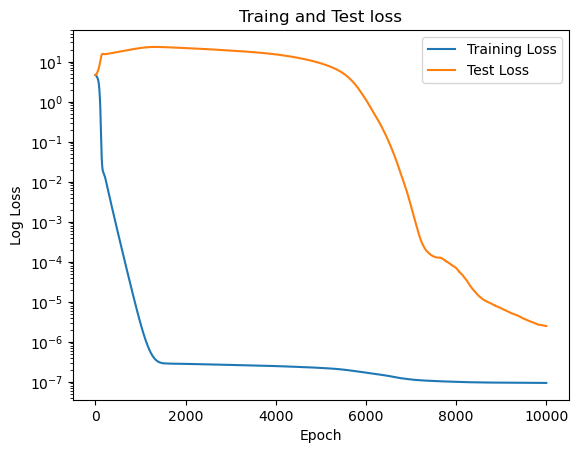

In [72]:
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.yscale("log")
plt.title("Traing and Test loss")
plt.legend()
plt.show()

## Training with Orthograd instead
In the paper https://arxiv.org/abs/2501.04697, the authors showed basically that the delay in generalization is due to the network following a "naive loss minimization" strategy by scaling the logits, which in return leads to an absorption error in the softmax which stops the training. The logits are scaled by simply scaling all the weights of the network (which works since it is approx. homogeneous). As fix, they suggest projecting the gradient to the subspace orthogonal to the direction of the weights.

The following code which does the orthogonal projection of the gradient is also from this paper.

In [73]:
class OrthoGrad(t.optim.Optimizer):
    def __init__(self, params, base_optimizer_cls=t.optim.SGD):
        """
        A wrapper optimizer that projects gradients to be orthogonal
        to the current parameters before performing an update.
        Args:
            params (iterable): Parameter groups to optimize
            base_optimizer_cls (Optimizer class): The base optimizer class
                (e.g., torch.optim.SGD, torch.optim.AdamW).
        """
        # Minimal defaults for OrthoGrad itself (nothing special needed).
        defaults = {}
        super().__init__(params, defaults)
        # Create the wrapped/base optimizer using *our* param_groups.
        self.base_optimizer = base_optimizer_cls(self.param_groups)

    @staticmethod
    def _orthogonalize_gradients(params):
        """
        Projects the gradient g to be orthogonal to the current weights w.
        g_orth = g - ( (w·g)/(w·w + eps) ) * w
        And then re-scales g_orth to have the same norm as g.
        """
        with t.no_grad():
            for p in params:
                if p.grad is not None:
                    w = p.view(-1)
                    g = p.grad.view(-1)

                    w_norm_sq = t.dot(w, w) + 1e-30
                    proj = t.dot(w, g) / w_norm_sq
                    g_orth = g - proj * w

                    g_norm = g.norm(2)
                    g_orth_norm = g_orth.norm(2) + 1e-30
                    g_orth_scaled = g_orth * (g_norm / g_orth_norm)

                    p.grad.copy_(g_orth_scaled.view_as(p.grad))

    def step(self, closure=None):
        for group in self.param_groups:
            self._orthogonalize_gradients(group['params'])
        return self.base_optimizer.step(closure)

def get_optimizer(model, lr,optimizer,beta2,orthogonal_gradients,weight_decay,adam_epsilon):

    param_group = dict(params=model.parameters())

    if optimizer in ("Adam", "AdamW"):
        param_group |= dict(lr=lr, betas=(0.9, beta2), eps=adam_epsilon)
    elif optimizer == "SGD":
        param_group |= dict(lr=lr, momentum=0.8 if orthogonal_gradients else 0.2)
    else:
        raise ValueError(f'Unsupported optimizer type: {optimizer}')

    param_group |= dict(weight_decay=weight_decay)
    base_optimizer_cls = getattr(optim, optimizer)

    if orthogonal_gradients:
        optimizer = OrthoGrad([param_group], base_optimizer_cls)
    else:
        optimizer = base_optimizer_cls([param_group])

    return optimizer

In [74]:
lr = 1e-3
weight_decay = 0.
optimizer = "AdamW"
beta2 = 0.98
orthogoal_gradients = True
adam_epsilon = 1e-8

model_ortho = Transformer(d_model,d_mlp,d_heads,d_vocab,num_heads,n_ctx,act_type).to(device=device)
optimizer_ortho = get_optimizer(model_ortho, lr,optimizer,beta2,orthogoal_gradients,weight_decay,adam_epsilon)

In [75]:
train_losses_ortho = []
test_losses_ortho = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_logits = model_ortho(train_dataset)
    train_loss = loss_fn(train_logits,train_labels)
    train_loss.backward()
    train_losses_ortho.append(train_loss.item())
    optimizer_ortho.step()
    optimizer_ortho.zero_grad()
    with t.inference_mode():
        test_logits = model_ortho(test_dataset)
        test_loss = loss_fn(test_logits,test_labels)
        test_losses_ortho.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  1%|          | 101/10000 [00:09<15:02, 10.97it/s]

Epoch 99 Train Loss 2.49433670167115 Test loss 6.969461133367866


  2%|▏         | 201/10000 [00:18<15:12, 10.74it/s]

Epoch 199 Train Loss 0.0998236826548971 Test loss 4.834650650912399


  3%|▎         | 301/10000 [00:27<14:09, 11.41it/s]

Epoch 299 Train Loss 0.005210148332024914 Test loss 2.519393540978759


  4%|▍         | 401/10000 [00:36<14:05, 11.35it/s]

Epoch 399 Train Loss 0.0009193714360459748 Test loss 1.4700323528934138


  5%|▌         | 501/10000 [00:44<13:51, 11.43it/s]

Epoch 499 Train Loss 0.00019886711224771756 Test loss 0.8881048749551367


  6%|▌         | 601/10000 [00:53<13:51, 11.30it/s]

Epoch 599 Train Loss 4.523446464392589e-05 Test loss 0.5363559310366297


  7%|▋         | 701/10000 [01:02<14:11, 10.92it/s]

Epoch 699 Train Loss 1.0682350684668862e-05 Test loss 0.3162303580535751


  8%|▊         | 801/10000 [01:11<13:25, 11.42it/s]

Epoch 799 Train Loss 2.727939631947375e-06 Test loss 0.18458388167014475


  9%|▉         | 901/10000 [01:20<14:39, 10.35it/s]

Epoch 899 Train Loss 7.778370978794352e-07 Test loss 0.10916757253306361


 10%|█         | 1001/10000 [01:29<13:41, 10.96it/s]

Epoch 999 Train Loss 2.442144909521593e-07 Test loss 0.06466251590942884


 11%|█         | 1101/10000 [01:38<12:55, 11.47it/s]

Epoch 1099 Train Loss 8.451481886455029e-08 Test loss 0.039314020064079816


 12%|█▏        | 1201/10000 [01:47<13:47, 10.64it/s]

Epoch 1199 Train Loss 3.3013486463578725e-08 Test loss 0.024129518904757535


 13%|█▎        | 1301/10000 [01:56<12:38, 11.47it/s]

Epoch 1299 Train Loss 1.4975826154746486e-08 Test loss 0.01533641815377078


 14%|█▍        | 1401/10000 [02:05<12:25, 11.54it/s]

Epoch 1399 Train Loss 8.011207016064148e-09 Test loss 0.010440127594341693


 15%|█▌        | 1501/10000 [02:14<12:16, 11.54it/s]

Epoch 1499 Train Loss 4.98160351476086e-09 Test loss 0.007582592230455592


 16%|█▌        | 1601/10000 [02:23<13:00, 10.76it/s]

Epoch 1599 Train Loss 3.4740058159429654e-09 Test loss 0.005832521435357167


 17%|█▋        | 1702/10000 [17:33<34:10,  4.05it/s]     

Epoch 1699 Train Loss 2.6248189782472755e-09 Test loss 0.0047198499826174994


 18%|█▊        | 1801/10000 [17:42<13:17, 10.28it/s]

Epoch 1799 Train Loss 2.0963095914230433e-09 Test loss 0.003951376757645032


 19%|█▉        | 1901/10000 [17:52<12:31, 10.78it/s]

Epoch 1899 Train Loss 1.7402910905060409e-09 Test loss 0.003401351096455481


 20%|██        | 2001/10000 [18:01<12:27, 10.71it/s]

Epoch 1999 Train Loss 1.4853087351329637e-09 Test loss 0.002984962051154898


 21%|██        | 2101/10000 [31:29<39:43,  3.31it/s]     

Epoch 2099 Train Loss 1.293910479070873e-09 Test loss 0.002661242258839399


 22%|██▏       | 2201/10000 [31:55<2:15:57,  1.05s/it]

Epoch 2199 Train Loss 1.1453399346213334e-09 Test loss 0.002409151713983753


 23%|██▎       | 2301/10000 [35:44<1:37:00,  1.32it/s] 

Epoch 2299 Train Loss 1.0267093727192152e-09 Test loss 0.002207303206608698


 24%|██▍       | 2402/10000 [48:23<14:28,  8.75it/s]     

Epoch 2399 Train Loss 9.298177028484806e-10 Test loss 0.0020368392147500115


 25%|██▌       | 2501/10000 [49:41<11:49, 10.58it/s]   

Epoch 2499 Train Loss 8.492551355636844e-10 Test loss 0.0018920658120821173


 26%|██▌       | 2601/10000 [49:50<12:14, 10.08it/s]

Epoch 2599 Train Loss 7.812796917182393e-10 Test loss 0.0017675810839635625


 27%|██▋       | 2701/10000 [50:00<10:56, 11.12it/s]

Epoch 2699 Train Loss 7.23101461907986e-10 Test loss 0.0016611827046008412


 28%|██▊       | 2802/10000 [50:11<09:53, 12.14it/s]

Epoch 2799 Train Loss 6.727451285235707e-10 Test loss 0.001568084893951121


 29%|██▉       | 2902/10000 [50:20<09:47, 12.07it/s]

Epoch 2899 Train Loss 6.288064736207862e-10 Test loss 0.0014862093718870733


 30%|███       | 3002/10000 [50:29<10:37, 10.98it/s]

Epoch 2999 Train Loss 5.901127319565065e-10 Test loss 0.0014133269325594274


 31%|███       | 3102/10000 [50:37<09:48, 11.72it/s]

Epoch 3099 Train Loss 5.55774995482646e-10 Test loss 0.0013464110091916629


 32%|███▏      | 3202/10000 [50:46<10:07, 11.19it/s]

Epoch 3199 Train Loss 5.251151487908175e-10 Test loss 0.0012868157507726393


 33%|███▎      | 3302/10000 [50:55<09:49, 11.37it/s]

Epoch 3299 Train Loss 4.975699312074079e-10 Test loss 0.0012321335562591191


 34%|███▍      | 3402/10000 [51:04<09:59, 11.01it/s]

Epoch 3399 Train Loss 4.726826545776494e-10 Test loss 0.0011834276023874825


 35%|███▌      | 3502/10000 [51:13<09:44, 11.12it/s]

Epoch 3499 Train Loss 4.5010414313890595e-10 Test loss 0.0011387774108474532


 36%|███▌      | 3602/10000 [51:22<09:35, 11.11it/s]

Epoch 3599 Train Loss 4.2952232492367227e-10 Test loss 0.001097745256387683


 37%|███▋      | 3702/10000 [51:31<08:49, 11.89it/s]

Epoch 3699 Train Loss 4.106971714456768e-10 Test loss 0.0010592922061515655


 38%|███▊      | 3802/10000 [51:39<09:06, 11.35it/s]

Epoch 3799 Train Loss 3.9341532349091287e-10 Test loss 0.0010233751214103087


 39%|███▉      | 3902/10000 [51:48<09:10, 11.07it/s]

Epoch 3899 Train Loss 3.774984980473769e-10 Test loss 0.0009897053993305875


 40%|████      | 4002/10000 [51:57<09:09, 10.91it/s]

Epoch 3999 Train Loss 3.627986332234785e-10 Test loss 0.0009580419376929381


 41%|████      | 4102/10000 [52:06<09:03, 10.85it/s]

Epoch 4099 Train Loss 3.491765682679241e-10 Test loss 0.0009281608708326442


 42%|████▏     | 4202/10000 [52:15<08:18, 11.64it/s]

Epoch 4199 Train Loss 3.365136846239572e-10 Test loss 0.0009001468088778799


 43%|████▎     | 4302/10000 [52:24<08:26, 11.24it/s]

Epoch 4299 Train Loss 3.247132754142885e-10 Test loss 0.0008737296022807094


 44%|████▍     | 4402/10000 [52:33<08:23, 11.12it/s]

Epoch 4399 Train Loss 3.1369025939392714e-10 Test loss 0.0008490612347476399


 45%|████▌     | 4502/10000 [52:42<08:07, 11.28it/s]

Epoch 4499 Train Loss 3.0337075196820863e-10 Test loss 0.0008257807645902681


 46%|████▌     | 4602/10000 [52:51<07:56, 11.32it/s]

Epoch 4599 Train Loss 2.936893035622097e-10 Test loss 0.0008035702672854296


 47%|████▋     | 4702/10000 [53:00<07:57, 11.09it/s]

Epoch 4699 Train Loss 2.8458941830181686e-10 Test loss 0.000782321779729502


 48%|████▊     | 4802/10000 [53:09<07:40, 11.30it/s]

Epoch 4799 Train Loss 2.760089502140561e-10 Test loss 0.0007620737219163288


 49%|████▉     | 4902/10000 [53:18<07:31, 11.29it/s]

Epoch 4899 Train Loss 2.6791804342690826e-10 Test loss 0.0007424786978532811


 50%|█████     | 5002/10000 [53:27<07:28, 11.15it/s]

Epoch 4999 Train Loss 2.6027614466427856e-10 Test loss 0.0007240131288047539


 51%|█████     | 5102/10000 [53:36<07:18, 11.16it/s]

Epoch 5099 Train Loss 2.5304203475233463e-10 Test loss 0.0007072387089620137


 52%|█████▏    | 5201/10000 [53:46<07:10, 11.16it/s]

Epoch 5199 Train Loss 2.4618959362898733e-10 Test loss 0.0006906405615134919


 53%|█████▎    | 5302/10000 [53:55<06:59, 11.20it/s]

Epoch 5299 Train Loss 2.396883232081551e-10 Test loss 0.0006745092344565308


 54%|█████▍    | 5402/10000 [54:04<06:56, 11.03it/s]

Epoch 5399 Train Loss 2.335134795220711e-10 Test loss 0.0006590931125893355


 55%|█████▌    | 5502/10000 [54:13<06:56, 10.79it/s]

Epoch 5499 Train Loss 2.2763879489857358e-10 Test loss 0.0006444001444624032


 56%|█████▌    | 5602/10000 [54:22<06:37, 11.05it/s]

Epoch 5599 Train Loss 2.2204547179052392e-10 Test loss 0.0006303576019263596


 57%|█████▋    | 5700/10000 [54:31<07:12,  9.95it/s]

Epoch 5699 Train Loss 2.167161763196821e-10 Test loss 0.0006166829267152132


 58%|█████▊    | 5802/10000 [54:40<06:19, 11.06it/s]

Epoch 5799 Train Loss 2.1162937582460382e-10 Test loss 0.0006037242375958651


 59%|█████▉    | 5902/10000 [54:50<06:06, 11.18it/s]

Epoch 5899 Train Loss 2.0676791645471937e-10 Test loss 0.0005911575926883481


 60%|██████    | 6002/10000 [54:59<06:01, 11.07it/s]

Epoch 5999 Train Loss 2.0212034481569897e-10 Test loss 0.000578837725687428


 61%|██████    | 6102/10000 [55:08<05:51, 11.10it/s]

Epoch 6099 Train Loss 1.9767117978775562e-10 Test loss 0.0005670194994469019


 62%|██████▏   | 6202/10000 [55:17<05:44, 11.01it/s]

Epoch 6199 Train Loss 1.9340881981568679e-10 Test loss 0.0005557490188137916


 63%|██████▎   | 6300/10000 [55:26<05:58, 10.31it/s]

Epoch 6299 Train Loss 1.8932064463007987e-10 Test loss 0.0005447287855794837


 64%|██████▍   | 6402/10000 [55:35<05:27, 10.97it/s]

Epoch 6399 Train Loss 1.8539686499089323e-10 Test loss 0.0005341814975622504


 65%|██████▌   | 6502/10000 [55:44<04:59, 11.69it/s]

Epoch 6499 Train Loss 1.8162717549486044e-10 Test loss 0.0005241001995446322


 66%|██████▌   | 6602/10000 [55:53<05:05, 11.12it/s]

Epoch 6599 Train Loss 1.7800203742993647e-10 Test loss 0.0005143568069858713


 67%|██████▋   | 6702/10000 [56:02<05:00, 10.98it/s]

Epoch 6699 Train Loss 1.7451492518688085e-10 Test loss 0.0005048231095376138


 68%|██████▊   | 6802/10000 [56:11<04:44, 11.23it/s]

Epoch 6799 Train Loss 1.7115896576915996e-10 Test loss 0.000495601222407587


 69%|██████▉   | 6902/10000 [56:20<04:47, 10.79it/s]

Epoch 6899 Train Loss 1.6792598168785758e-10 Test loss 0.00048661983217756767


 70%|███████   | 7002/10000 [56:29<04:28, 11.18it/s]

Epoch 6999 Train Loss 1.6480828848434896e-10 Test loss 0.00047791962207254055


 71%|███████   | 7102/10000 [56:38<04:20, 11.12it/s]

Epoch 7099 Train Loss 1.6180201674420695e-10 Test loss 0.00046935214828563174


 72%|███████▏  | 7202/10000 [56:47<04:12, 11.09it/s]

Epoch 7199 Train Loss 1.5889868864390516e-10 Test loss 0.0004612340089141991


 73%|███████▎  | 7301/10000 [56:56<04:00, 11.22it/s]

Epoch 7299 Train Loss 1.560954465590798e-10 Test loss 0.00045343533538403085


 74%|███████▍  | 7401/10000 [57:06<04:04, 10.63it/s]

Epoch 7399 Train Loss 1.5338664739369732e-10 Test loss 0.00044592182375831693


 75%|███████▌  | 7501/10000 [57:15<03:44, 11.12it/s]

Epoch 7499 Train Loss 1.507684328276871e-10 Test loss 0.0004387209076384077


 76%|███████▌  | 7601/10000 [57:24<03:36, 11.09it/s]

Epoch 7599 Train Loss 1.4823514505121836e-10 Test loss 0.0004317570273000031


 77%|███████▋  | 7701/10000 [57:33<03:28, 11.02it/s]

Epoch 7699 Train Loss 1.4578308468472471e-10 Test loss 0.00042493143780620386


 78%|███████▊  | 7801/10000 [57:42<03:21, 10.90it/s]

Epoch 7799 Train Loss 1.4340828112689848e-10 Test loss 0.00041828280602115603


 79%|███████▉  | 7901/10000 [57:51<03:09, 11.10it/s]

Epoch 7899 Train Loss 1.4110607663414574e-10 Test loss 0.0004117925077402453


 80%|████████  | 8001/10000 [58:00<03:01, 11.01it/s]

Epoch 7999 Train Loss 1.3887488557823242e-10 Test loss 0.00040563653333296624


 81%|████████  | 8101/10000 [58:09<02:52, 11.02it/s]

Epoch 8099 Train Loss 1.367112577699761e-10 Test loss 0.0003995952555309668


 82%|████████▏ | 8201/10000 [58:18<02:41, 11.11it/s]

Epoch 8199 Train Loss 1.3461014739916686e-10 Test loss 0.00039376437338189155


 83%|████████▎ | 8301/10000 [58:27<02:32, 11.14it/s]

Epoch 8299 Train Loss 1.3257144635478832e-10 Test loss 0.00038798851511542614


 84%|████████▍ | 8401/10000 [58:36<02:26, 10.94it/s]

Epoch 8399 Train Loss 1.3059263629537377e-10 Test loss 0.0003824156294775062


 85%|████████▌ | 8501/10000 [58:45<02:14, 11.16it/s]

Epoch 8499 Train Loss 1.2866942559127147e-10 Test loss 0.00037702456035930144


 86%|████████▌ | 8601/10000 [58:54<02:02, 11.41it/s]

Epoch 8599 Train Loss 1.268008291260916e-10 Test loss 0.00037169589509224545


 87%|████████▋ | 8701/10000 [59:03<01:55, 11.23it/s]

Epoch 8699 Train Loss 1.2498440315024765e-10 Test loss 0.0003665365596769012


 88%|████████▊ | 8801/10000 [59:12<01:46, 11.28it/s]

Epoch 8799 Train Loss 1.2321748871500446e-10 Test loss 0.0003614512405403273


 89%|████████▉ | 8901/10000 [59:21<01:40, 10.97it/s]

Epoch 8899 Train Loss 1.2149897882335794e-10 Test loss 0.00035653536114913826


 90%|█████████ | 9001/10000 [59:30<01:30, 11.07it/s]

Epoch 8999 Train Loss 1.1982611522810077e-10 Test loss 0.00035172561075369127


 91%|█████████ | 9101/10000 [59:40<01:20, 11.14it/s]

Epoch 9099 Train Loss 1.181952891142792e-10 Test loss 0.0003469023353986134


 92%|█████████▏| 9201/10000 [59:49<01:11, 11.15it/s]

Epoch 9199 Train Loss 1.166071259363812e-10 Test loss 0.0003422848263304438


 93%|█████████▎| 9301/10000 [59:58<01:03, 11.08it/s]

Epoch 9299 Train Loss 1.150598464262817e-10 Test loss 0.00033785373948063134


 94%|█████████▍| 9401/10000 [1:00:07<00:53, 11.13it/s]

Epoch 9399 Train Loss 1.1355235019638453e-10 Test loss 0.0003334838818333059


 95%|█████████▌| 9501/10000 [1:00:16<00:45, 11.02it/s]

Epoch 9499 Train Loss 1.1208294476637505e-10 Test loss 0.0003288713956336311


 96%|█████████▌| 9601/10000 [1:00:25<00:35, 11.22it/s]

Epoch 9599 Train Loss 1.1065037364075584e-10 Test loss 0.0003244430532577599


 97%|█████████▋| 9701/10000 [1:00:34<00:27, 10.96it/s]

Epoch 9699 Train Loss 1.0925321784277188e-10 Test loss 0.00032014379003027005


 98%|█████████▊| 9801/10000 [1:00:43<00:18, 11.01it/s]

Epoch 9799 Train Loss 1.0789029924560914e-10 Test loss 0.00031600870691309984


 99%|█████████▉| 9902/10000 [1:00:52<00:08, 11.11it/s]

Epoch 9899 Train Loss 1.0656020595402027e-10 Test loss 0.00031200888797886585


100%|██████████| 10000/10000 [1:01:01<00:00,  2.73it/s]

Epoch 9999 Train Loss 1.0526108977320666e-10 Test loss 0.000308072873718711


In [76]:
print(train_losses_ortho)

[4.632420038871681, 4.5918414052808405, 4.576953334068216, 4.570277016708376, 4.564112240609464, 4.557146215109135, 4.549958148686731, 4.543138123847747, 4.5366111583553606, 4.530169666756731, 4.52347083055826, 4.516427665117814, 4.508978009577815, 4.5011820890262495, 4.493072001996621, 4.4846227409783515, 4.475735065318686, 4.466266156335975, 4.456172965107057, 4.445517968783095, 4.434250780631692, 4.422339224101285, 4.409796994700354, 4.396548417823389, 4.382710160106736, 4.368299435522457, 4.353352018007906, 4.337903265437918, 4.32200286711236, 4.305600324379358, 4.288738374129205, 4.271490684400207, 4.253852535189546, 4.235930815089566, 4.217853977787011, 4.1996160222204635, 4.181283417479351, 4.1628710290263475, 4.14436569321273, 4.1257509650257695, 4.107058079019469, 4.088290099194472, 4.069356166228662, 4.050246058853954, 4.031007631752158, 4.011680618799173, 3.99225621266403, 3.972671095439648, 3.9528798559682383, 3.932890471176982, 3.912630300019275, 3.8920958688445544, 3.8712

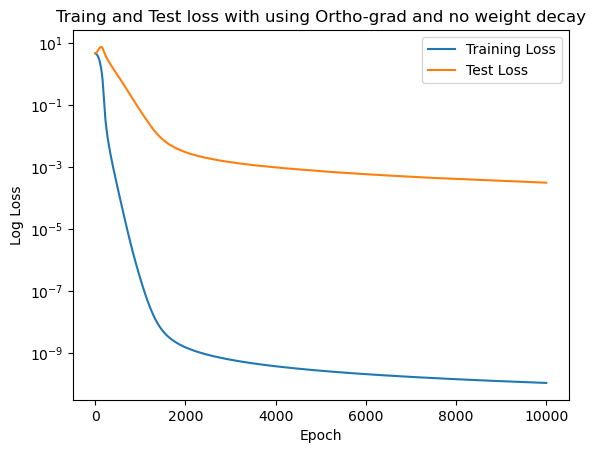

In [77]:
plt.plot(train_losses_ortho,label="Training Loss")
plt.plot(test_losses_ortho,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.yscale("log")
plt.title("Traing and Test loss with using Ortho-grad and no weight decay")
plt.legend()
plt.show()